In [ ]:
# !pip install imblearn


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import sklearn.feature_extraction

#from collections import Counter

#import sklearn.ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#import pickle
from sklearn import preprocessing
from sklearn import metrics
import imblearn
 

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
#from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier

%matplotlib inline


/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [100]:
global plot_auc
plot_auc = False

In [126]:
##### FUNCTIONS #####

## função para plotar matriz de confusão
def plot_cm(cm, labels):
    
    # calcula porcentagens 
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()) )

    # Show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def plot_auc_curve(text_clf, X_test, y_test):
    y_pred_proba = text_clf.predict_proba(X_test)[::,1]
    fpr, tpr, _  = sklearn.metrics.roc_curve(y_test,  y_pred_proba)
    auc          = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)

    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

## FUNCTION TO RUN MODEL OF THE ML
def run_ml(X_train,X_test,y_train,y_test):

    modelos = [ SVC(),#C= 10, gamma= 0.001, kernel= 'linear', probability= False),
                RandomForestClassifier(),#criterion='entropy', max_depth= None, max_features='sqrt',n_estimators= 10000),
                LogisticRegression(),#solver='lbfgs',multi_class='multinomial',class_weight='balanced',random_state=0),
                #DecisionTreeClassifier(),#max_depth=20, min_samples_split=50), #81.3%
                #ExtraTreesClassifier(),#n_estimators=10, max_depth=None,min_samples_split=2, random_state=0), #80.6%
                #AdaBoostClassifier(),#base_estimator=SVC(),
                                   #learning_rate=1.0,n_estimators=400,algorithm='SAMME'),#n_estimators=10),
                #GradientBoostingClassifier(),#n_estimators=1000, learning_rate=1.0,max_depth=1, random_state=0),
                GaussianNB(),
                #BernoulliNB(),
                #MultinomialNB(),
                KNeighborsClassifier(),#n_neighbors=11),
                BaggingClassifier(),#RandomForestClassifier(),max_samples=0.5,max_features=0.5)
                ]


    for m in modelos:
        print("\n==>",m.__class__.__name__)
        text_clf = Pipeline([('clf', m )])

        text_clf  = text_clf.fit(np.asarray(X_train), y_train)
        predicted = text_clf.predict(np.asarray(X_test))
        print("  Accuracy  = %f \n" % accuracy_score(y_test, predicted))
        labels = list(np.unique(y_train)) #[0,1]
        cm     = confusion_matrix(y_test, predicted,labels=labels)    
        plot_cm(cm,labels)

        if hasattr(text_clf, 'predict_proba') and plot_auc:
            plot_auc_curve(text_clf, X_test, y_test)

    print("================================================================================================")

    ##  CHECKING FEATURES IMPORTANCES 
    for m in modelos:
        print("\n==>",m.__class__.__name__)
        cols = X_train.columns
        m.fit(np.asarray(X_train),y_train)

        if hasattr(m, 'feature_importances_'):
            x_labels = X_train.columns[:]
            prob     = list()        
            cols     = list()        
            features = m.feature_importances_
            for i,l in zip(x_labels,features):
                if l*100 > int( np.mean(features)*100 ):
                    cols.append(i)
            print("  Cols: ", cols)

        text_clf  = m.fit(np.asarray(X_train.loc[:,cols]), y_train)
        predicted = text_clf.predict(np.asarray(X_test.loc[:,cols]))

        print("  Accuracy  = %f \n" % accuracy_score(y_test, predicted))
        labels = list(np.unique(y_train)) #[0,1]
        cm     = confusion_matrix(y_test, predicted,labels=labels)    
        plot_cm(cm,labels)
        
        if hasattr(text_clf, 'predict_proba') and plot_auc:
            plot_auc_curve(text_clf, X_test.loc[:,cols], y_test)
           


In [102]:
dados = pd.read_csv("winequality.csv", sep = ';')

In [103]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 659.9+ KB


In [ ]:
dados.plot(kind='bar', x='alcohol',)

In [104]:
## identificando registros inconsistentes na coluna alcohol
lista = list()
for i,a in dados.iterrows():
    if len(a["alcohol"]) > 5:
        #print(i,a["alcohol"])
        lista.append(i)

In [105]:
# eliminando registro inconsistentes
dados = dados.drop(index=lista)

In [106]:
dados.alcohol = pd.to_numeric(dados.alcohol)

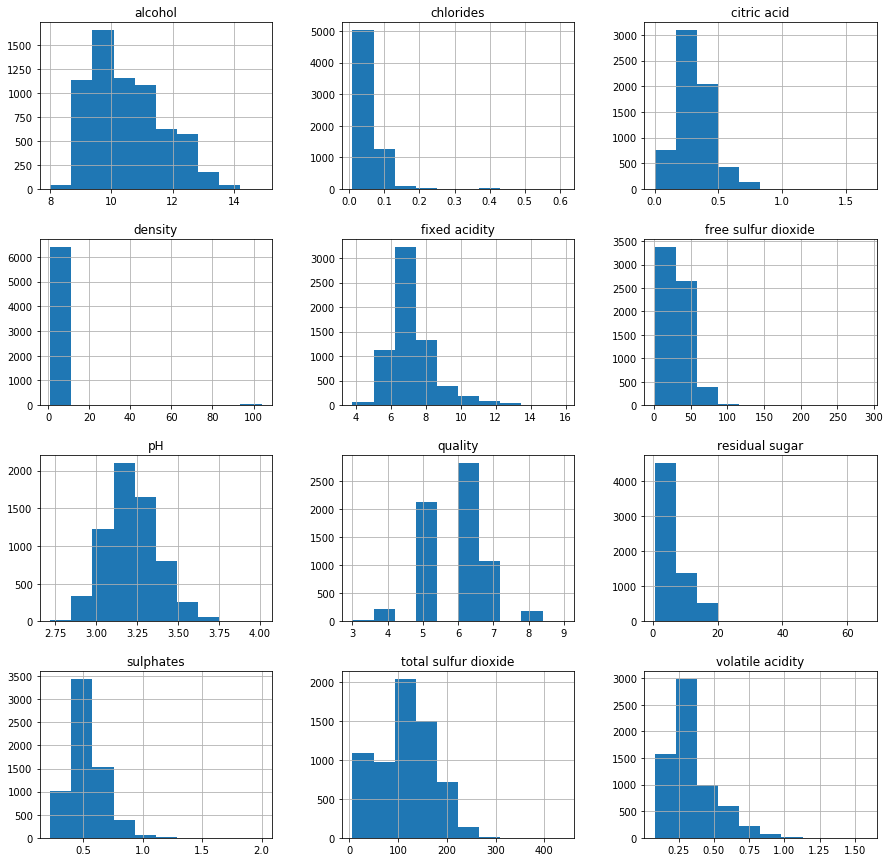

In [107]:
#plt.figure(figsize=(10,10))
dados.iloc[:,1:].hist(figsize=(15,15))
plt.show()

# <font color = 'red'> 1 - ANÁLISE COM 3 CLASSES </font>

In [108]:
#Defining the splits for categories. 1–4 will be poor quality, 5–6 will be average, 7–10 will be great
bins = [1,4,6,10]

#0 for low quality, 1 for average, 2 for great quality
quality_labels=[0,1,2]

dados['class'] = pd.cut(dados['quality'], bins=bins, labels=quality_labels, include_lowest=True)

In [109]:
#Defining the splits for categories. 1–4 will be poor quality, 5–6 will be average, 7–10 will be great
bins = [1,4,6,10]

#0 for low quality, 1 for average, 2 for great quality
quality_labels=[0,1,2]

dados['class'] = pd.cut(dados['quality'], bins=bins, labels=quality_labels, include_lowest=True)
label_type    = preprocessing.LabelEncoder()
dados["type"] = label_type.fit_transform(dados.type)

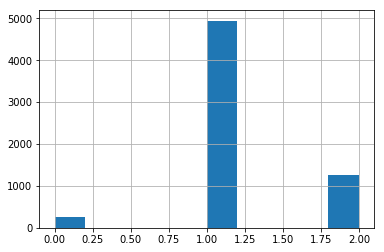

In [110]:
dados.loc[:,'class'].hist()

In [111]:
dados_clean = dados.drop(columns=['quality'])

In [112]:
#dados_clean.head()

In [113]:
x_train, x_test, y_train, y_test = train_test_split(dados_clean.iloc[:,:-1], 
                                                    dados_clean.iloc[:,-1:], 
                                                    test_size=0.30, random_state=4)

In [114]:
x_train.head()
#y_train

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
600,1,6.7,0.30,0.35,1.4,0.180,36.0,160.0,0.9937,3.11,0.54,9.4
703,1,6.4,0.33,0.28,1.1,0.038,30.0,110.0,0.9917,3.12,0.42,10.5
3840,1,6.7,0.37,0.25,2.5,0.028,24.0,84.0,0.9909,3.14,0.36,11.7
1718,1,9.3,0.20,0.33,1.7,0.050,28.0,178.0,0.9954,3.16,0.43,9.0
4991,0,7.7,0.49,0.26,1.9,0.062,9.0,31.0,0.9966,3.39,0.64,9.6


In [115]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4519 entries, 600 to 1146
Data columns (total 12 columns):
type                    4519 non-null int64
fixed acidity           4519 non-null float64
volatile acidity        4519 non-null float64
citric acid             4519 non-null float64
residual sugar          4519 non-null float64
chlorides               4519 non-null float64
free sulfur dioxide     4519 non-null float64
total sulfur dioxide    4519 non-null float64
density                 4519 non-null float64
pH                      4519 non-null float64
sulphates               4519 non-null float64
alcohol                 4519 non-null float64
dtypes: float64(11), int64(1)
memory usage: 459.0 KB



==> SVC
  Accuracy  = 0.794634 

Confusion Matrix Stats
0/0: 2.50% (2/80)
0/1: 96.25% (77/80)
0/2: 1.25% (1/80)
1/0: 0.07% (1/1478)
1/1: 96.75% (1430/1478)
1/2: 3.18% (47/1478)
2/0: 0.00% (0/380)
2/1: 71.58% (272/380)
2/2: 28.42% (108/380)


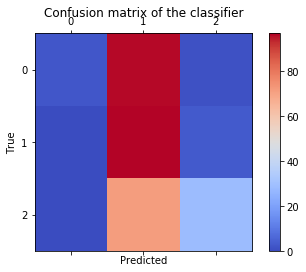


==> RandomForestClassifier
  Accuracy  = 0.823529 

Confusion Matrix Stats
0/0: 12.50% (10/80)
0/1: 86.25% (69/80)
0/2: 1.25% (1/80)
1/0: 0.54% (8/1478)
1/1: 94.11% (1391/1478)
1/2: 5.35% (79/1478)
2/0: 0.00% (0/380)
2/1: 48.68% (185/380)
2/2: 51.32% (195/380)


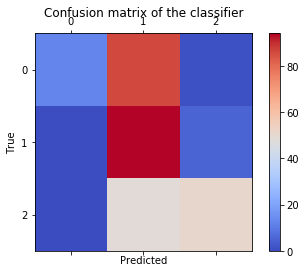

ValueError: multiclass format is not supported

In [116]:
run_ml(x_train,x_test,y_train,y_test)


### <font color = 'red'>  1.1 - MODELOS COM DADOS BALANCEADOS </font>

In [90]:
data_o, target_o = SMOTE().fit_sample(dados_clean.iloc[:,:-1],dados_clean.iloc[:,-1:], )

In [91]:
data_o = pd.DataFrame(data_o, columns= dados_clean.iloc[:,:-1].columns)
target_o = pd.DataFrame(target_o, columns= dados_clean.iloc[:,-1:].columns)

data_o.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [92]:
x_train, x_test, y_train, y_test = train_test_split(data_o,target_o, 
                                                    test_size=0.30, random_state=4)


==> SVC
  Accuracy  = 0.857079 

Confusion Matrix Stats
0/0: 91.61% (1343/1466)
0/1: 7.16% (105/1466)
0/2: 1.23% (18/1466)
1/0: 10.11% (154/1523)
1/1: 74.85% (1140/1523)
1/2: 15.04% (229/1523)
2/0: 1.57% (23/1461)
2/1: 7.32% (107/1461)
2/2: 91.10% (1331/1461)


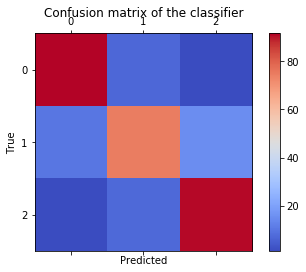


==> RandomForestClassifier
  Accuracy  = 0.895506 

Confusion Matrix Stats
0/0: 96.73% (1418/1466)
0/1: 2.52% (37/1466)
0/2: 0.75% (11/1466)
1/0: 5.98% (91/1523)
1/1: 81.81% (1246/1523)
1/2: 12.21% (186/1523)
2/0: 0.75% (11/1461)
2/1: 8.83% (129/1461)
2/2: 90.42% (1321/1461)


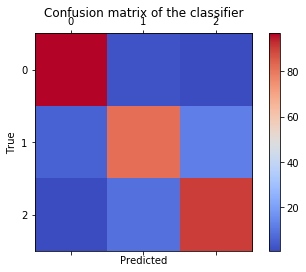


==> LogisticRegression
  Accuracy  = 0.658876 

Confusion Matrix Stats
0/0: 73.06% (1071/1466)
0/1: 17.53% (257/1466)
0/2: 9.41% (138/1466)
1/0: 26.00% (396/1523)
1/1: 43.20% (658/1523)
1/2: 30.79% (469/1523)
2/0: 4.86% (71/1461)
2/1: 12.80% (187/1461)
2/2: 82.34% (1203/1461)


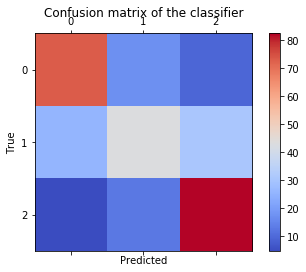


==> GaussianNB
  Accuracy  = 0.531461 

Confusion Matrix Stats
0/0: 55.12% (808/1466)
0/1: 10.37% (152/1466)
0/2: 34.52% (506/1466)
1/0: 28.23% (430/1523)
1/1: 21.86% (333/1523)
1/2: 49.90% (760/1523)
2/0: 5.89% (86/1461)
2/1: 10.34% (151/1461)
2/2: 83.78% (1224/1461)


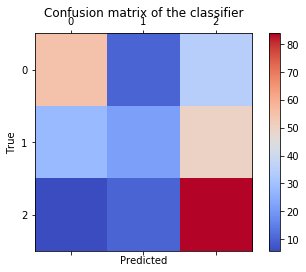


==> KNeighborsClassifier
  Accuracy  = 0.805169 

Confusion Matrix Stats
0/0: 93.72% (1374/1466)
0/1: 4.09% (60/1466)
0/2: 2.18% (32/1466)
1/0: 18.32% (279/1523)
1/1: 58.44% (890/1523)
1/2: 23.24% (354/1523)
2/0: 3.49% (51/1461)
2/1: 6.23% (91/1461)
2/2: 90.28% (1319/1461)


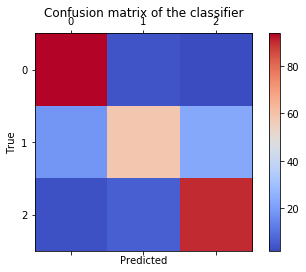


==> BaggingClassifier
  Accuracy  = 0.895281 

Confusion Matrix Stats
0/0: 96.32% (1412/1466)
0/1: 2.86% (42/1466)
0/2: 0.82% (12/1466)
1/0: 6.70% (102/1523)
1/1: 81.22% (1237/1523)
1/2: 12.08% (184/1523)
2/0: 0.62% (9/1461)
2/1: 8.01% (117/1461)
2/2: 91.38% (1335/1461)


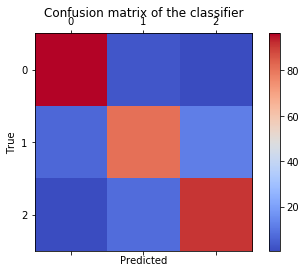


==> SVC
  Accuracy  = 0.857079 

Confusion Matrix Stats
0/0: 91.61% (1343/1466)
0/1: 7.16% (105/1466)
0/2: 1.23% (18/1466)
1/0: 10.11% (154/1523)
1/1: 74.85% (1140/1523)
1/2: 15.04% (229/1523)
2/0: 1.57% (23/1461)
2/1: 7.32% (107/1461)
2/2: 91.10% (1331/1461)


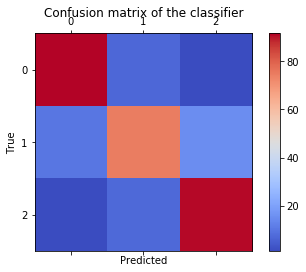


==> RandomForestClassifier
  Cols:  ['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol']
  Accuracy  = 0.877303 

Confusion Matrix Stats
0/0: 95.23% (1396/1466)
0/1: 3.75% (55/1466)
0/2: 1.02% (15/1466)
1/0: 8.08% (123/1523)
1/1: 79.71% (1214/1523)
1/2: 12.21% (186/1523)
2/0: 1.30% (19/1461)
2/1: 10.13% (148/1461)
2/2: 88.57% (1294/1461)


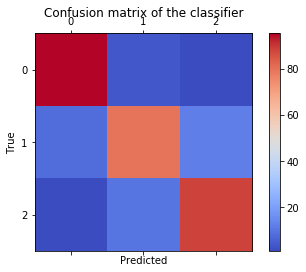


==> LogisticRegression
  Accuracy  = 0.658876 

Confusion Matrix Stats
0/0: 73.06% (1071/1466)
0/1: 17.53% (257/1466)
0/2: 9.41% (138/1466)
1/0: 26.00% (396/1523)
1/1: 43.20% (658/1523)
1/2: 30.79% (469/1523)
2/0: 4.86% (71/1461)
2/1: 12.80% (187/1461)
2/2: 82.34% (1203/1461)


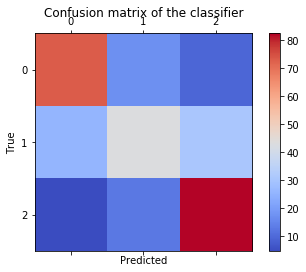


==> GaussianNB
  Accuracy  = 0.531461 

Confusion Matrix Stats
0/0: 55.12% (808/1466)
0/1: 10.37% (152/1466)
0/2: 34.52% (506/1466)
1/0: 28.23% (430/1523)
1/1: 21.86% (333/1523)
1/2: 49.90% (760/1523)
2/0: 5.89% (86/1461)
2/1: 10.34% (151/1461)
2/2: 83.78% (1224/1461)


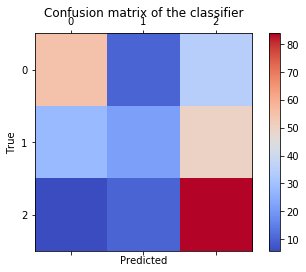


==> KNeighborsClassifier
  Accuracy  = 0.805169 

Confusion Matrix Stats
0/0: 93.72% (1374/1466)
0/1: 4.09% (60/1466)
0/2: 2.18% (32/1466)
1/0: 18.32% (279/1523)
1/1: 58.44% (890/1523)
1/2: 23.24% (354/1523)
2/0: 3.49% (51/1461)
2/1: 6.23% (91/1461)
2/2: 90.28% (1319/1461)


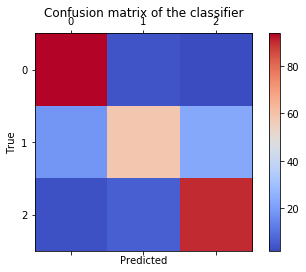


==> BaggingClassifier
  Accuracy  = 0.886067 

Confusion Matrix Stats
0/0: 95.50% (1400/1466)
0/1: 3.82% (56/1466)
0/2: 0.68% (10/1466)
1/0: 7.03% (107/1523)
1/1: 80.24% (1222/1523)
1/2: 12.74% (194/1523)
2/0: 0.55% (8/1461)
2/1: 9.03% (132/1461)
2/2: 90.42% (1321/1461)


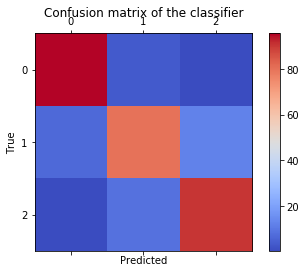

In [93]:
run_ml(x_train,x_test,y_train,y_test)


### <font color = 'red'>  1.2 - MODELOS (3 CLASSES) COM DADOS NORMALIZADOS </font>


In [ ]:
density
free sulfur
residual sugar

In [96]:
data_on = preprocessing.scale(dados_clean.iloc[:,:-1])
data_on = pd.DataFrame(data_on, columns=dados_clean.iloc[:,:-1].columns)
x_train, x_test, y_train, y_test = train_test_split(data_on, dados_clean.iloc[:,-1:], 
                                                            test_size=0.20, random_state=4)



==> SVC
  Accuracy  = 0.790248 

Confusion Matrix Stats
0/0: 0.00% (0/46)
0/1: 100.00% (46/46)
0/2: 0.00% (0/46)
1/0: 0.00% (0/988)
1/1: 96.15% (950/988)
1/2: 3.85% (38/988)
2/0: 0.00% (0/258)
2/1: 72.48% (187/258)
2/2: 27.52% (71/258)


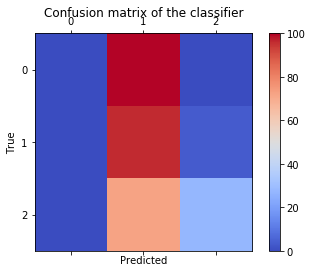


==> RandomForestClassifier
  Accuracy  = 0.816563 

Confusion Matrix Stats
0/0: 8.70% (4/46)
0/1: 89.13% (41/46)
0/2: 2.17% (1/46)
1/0: 0.61% (6/988)
1/1: 94.53% (934/988)
1/2: 4.86% (48/988)
2/0: 0.00% (0/258)
2/1: 54.65% (141/258)
2/2: 45.35% (117/258)


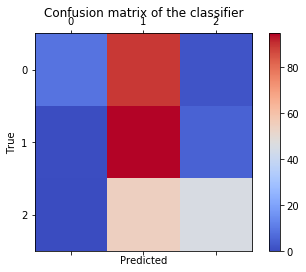


==> LogisticRegression
  Accuracy  = 0.783282 

Confusion Matrix Stats
0/0: 0.00% (0/46)
0/1: 100.00% (46/46)
0/2: 0.00% (0/46)
1/0: 0.00% (0/988)
1/1: 96.15% (950/988)
1/2: 3.85% (38/988)
2/0: 0.00% (0/258)
2/1: 75.97% (196/258)
2/2: 24.03% (62/258)


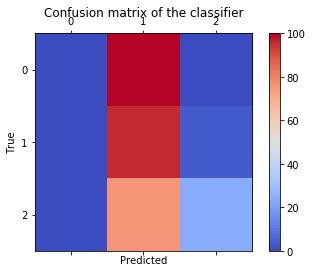


==> GaussianNB
  Accuracy  = 0.652477 

Confusion Matrix Stats
0/0: 17.39% (8/46)
0/1: 56.52% (26/46)
0/2: 26.09% (12/46)
1/0: 4.25% (42/988)
1/1: 66.50% (657/988)
1/2: 29.25% (289/988)
2/0: 0.78% (2/258)
2/1: 30.23% (78/258)
2/2: 68.99% (178/258)


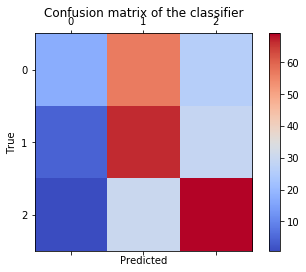


==> KNeighborsClassifier
  Accuracy  = 0.810372 

Confusion Matrix Stats
0/0: 0.00% (0/46)
0/1: 95.65% (44/46)
0/2: 4.35% (2/46)
1/0: 0.30% (3/988)
1/1: 91.50% (904/988)
1/2: 8.20% (81/988)
2/0: 0.00% (0/258)
2/1: 44.57% (115/258)
2/2: 55.43% (143/258)


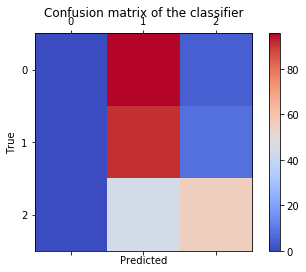


==> BaggingClassifier
  Accuracy  = 0.832043 

Confusion Matrix Stats
0/0: 15.22% (7/46)
0/1: 80.43% (37/46)
0/2: 4.35% (2/46)
1/0: 1.01% (10/988)
1/1: 94.03% (929/988)
1/2: 4.96% (49/988)
2/0: 0.00% (0/258)
2/1: 46.12% (119/258)
2/2: 53.88% (139/258)


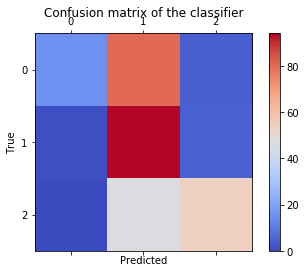


==> SVC
  Accuracy  = 0.790248 

Confusion Matrix Stats
0/0: 0.00% (0/46)
0/1: 100.00% (46/46)
0/2: 0.00% (0/46)
1/0: 0.00% (0/988)
1/1: 96.15% (950/988)
1/2: 3.85% (38/988)
2/0: 0.00% (0/258)
2/1: 72.48% (187/258)
2/2: 27.52% (71/258)


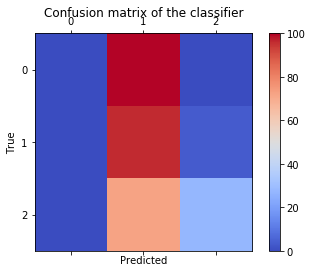


==> RandomForestClassifier
  Cols:  ['volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
  Accuracy  = 0.836687 

Confusion Matrix Stats
0/0: 19.57% (9/46)
0/1: 80.43% (37/46)
0/2: 0.00% (0/46)
1/0: 0.51% (5/988)
1/1: 94.74% (936/988)
1/2: 4.76% (47/988)
2/0: 0.00% (0/258)
2/1: 47.29% (122/258)
2/2: 52.71% (136/258)


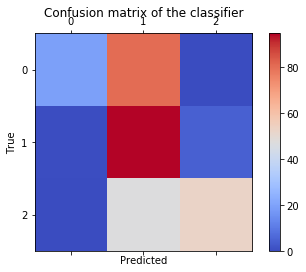


==> LogisticRegression
  Accuracy  = 0.783282 

Confusion Matrix Stats
0/0: 0.00% (0/46)
0/1: 100.00% (46/46)
0/2: 0.00% (0/46)
1/0: 0.00% (0/988)
1/1: 96.15% (950/988)
1/2: 3.85% (38/988)
2/0: 0.00% (0/258)
2/1: 75.97% (196/258)
2/2: 24.03% (62/258)


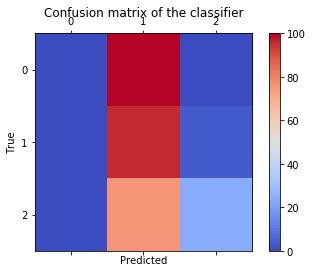


==> GaussianNB
  Accuracy  = 0.652477 

Confusion Matrix Stats
0/0: 17.39% (8/46)
0/1: 56.52% (26/46)
0/2: 26.09% (12/46)
1/0: 4.25% (42/988)
1/1: 66.50% (657/988)
1/2: 29.25% (289/988)
2/0: 0.78% (2/258)
2/1: 30.23% (78/258)
2/2: 68.99% (178/258)


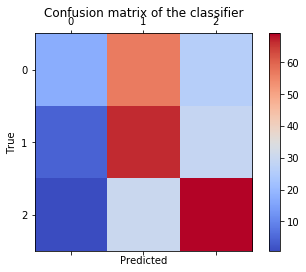


==> KNeighborsClassifier
  Accuracy  = 0.810372 

Confusion Matrix Stats
0/0: 0.00% (0/46)
0/1: 95.65% (44/46)
0/2: 4.35% (2/46)
1/0: 0.30% (3/988)
1/1: 91.50% (904/988)
1/2: 8.20% (81/988)
2/0: 0.00% (0/258)
2/1: 44.57% (115/258)
2/2: 55.43% (143/258)


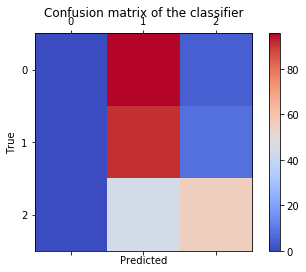


==> BaggingClassifier
  Accuracy  = 0.832043 

Confusion Matrix Stats
0/0: 13.04% (6/46)
0/1: 86.96% (40/46)
0/2: 0.00% (0/46)
1/0: 0.51% (5/988)
1/1: 94.53% (934/988)
1/2: 4.96% (49/988)
2/0: 0.00% (0/258)
2/1: 47.67% (123/258)
2/2: 52.33% (135/258)


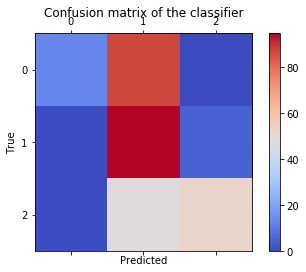

In [97]:
run_ml(x_train,x_test,y_train,y_test)


# <font color = 'red'> 2 - ANÁLISE COM 2 CLASSES </font>

In [61]:
np.mean(dados.quality)

5.81709772340096

In [132]:
#Defining the splits for categories. 1–4 will be poor quality, 5–6 will be average, 7–10 will be great
bins = [2, 6.5, 8]

#1 for average, 2 for great quality
quality_labels=[0,1]


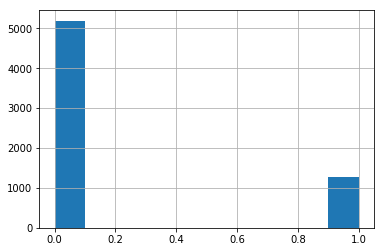

In [133]:
dados['class'] = pd.cut(dados['quality'], bins=bins, labels=quality_labels, include_lowest=True)
label_type    = preprocessing.LabelEncoder()
dados["type"] = label_type.fit_transform(dados.type)

dados.loc[:,'class'].hist()

In [121]:
dados_clean = dados.drop(columns=['quality'])


In [122]:
x_train, x_test, y_train, y_test = train_test_split(dados_clean.iloc[:,:-1], 
                                                    dados_clean.iloc[:,-1:], 
                                                    test_size=0.30, random_state=4)

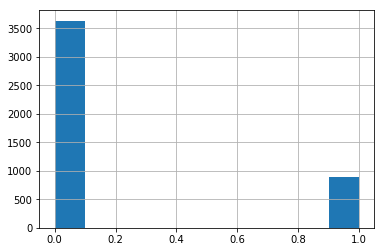

In [123]:
y_train.loc[:,'class'].hist()

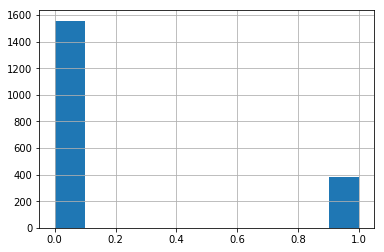

In [124]:
y_test.loc[:,'class'].hist()


==> SVC
  Accuracy  = 0.832817 

Confusion Matrix Stats
0/0: 96.98% (1511/1558)
0/1: 3.02% (47/1558)
1/0: 72.89% (277/380)
1/1: 27.11% (103/380)


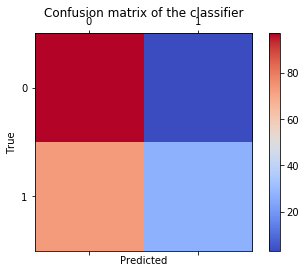


==> RandomForestClassifier
  Accuracy  = 0.871001 

Confusion Matrix Stats
0/0: 96.02% (1496/1558)
0/1: 3.98% (62/1558)
1/0: 49.47% (188/380)
1/1: 50.53% (192/380)


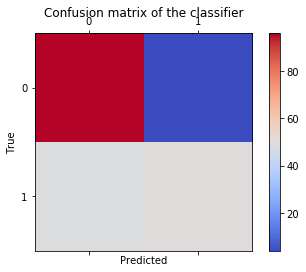

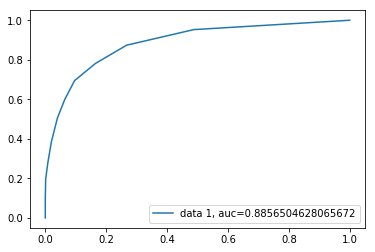


==> LogisticRegression
  Accuracy  = 0.815273 

Confusion Matrix Stats
0/0: 96.98% (1511/1558)
0/1: 3.02% (47/1558)
1/0: 81.84% (311/380)
1/1: 18.16% (69/380)


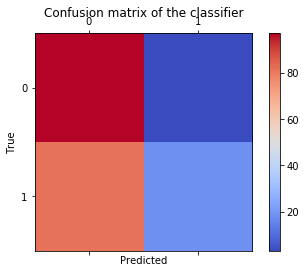

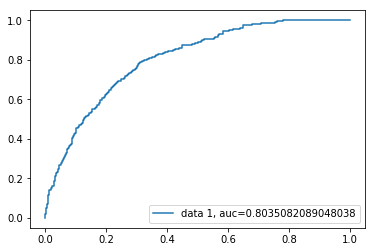


==> GaussianNB
  Accuracy  = 0.725490 

Confusion Matrix Stats
0/0: 72.85% (1135/1558)
0/1: 27.15% (423/1558)
1/0: 28.68% (109/380)
1/1: 71.32% (271/380)


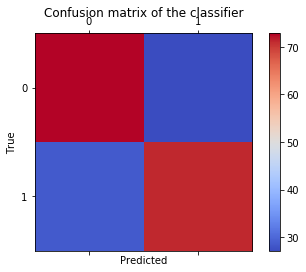

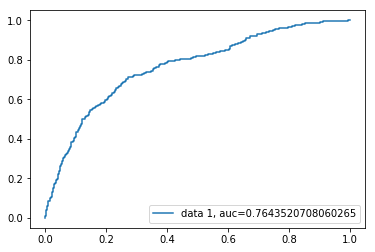


==> KNeighborsClassifier
  Accuracy  = 0.812178 

Confusion Matrix Stats
0/0: 92.81% (1446/1558)
0/1: 7.19% (112/1558)
1/0: 66.32% (252/380)
1/1: 33.68% (128/380)


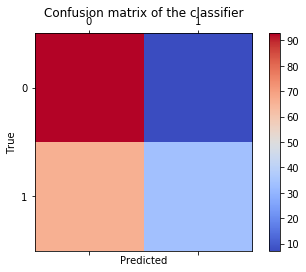

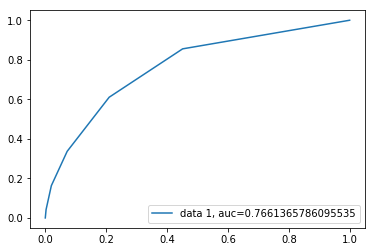


==> BaggingClassifier
  Accuracy  = 0.866873 

Confusion Matrix Stats
0/0: 95.70% (1491/1558)
0/1: 4.30% (67/1558)
1/0: 50.26% (191/380)
1/1: 49.74% (189/380)


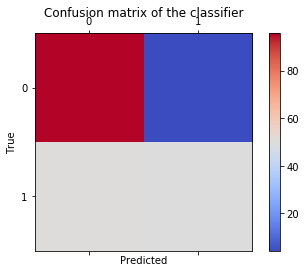

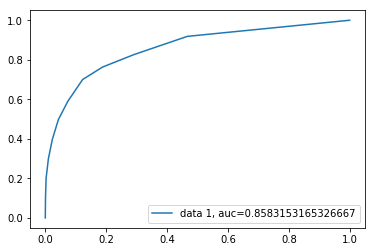


==> SVC
  Accuracy  = 0.832817 

Confusion Matrix Stats
0/0: 96.98% (1511/1558)
0/1: 3.02% (47/1558)
1/0: 72.89% (277/380)
1/1: 27.11% (103/380)


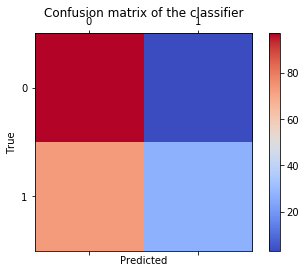


==> RandomForestClassifier
  Cols:  ['residual sugar', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
  Accuracy  = 0.862229 

Confusion Matrix Stats
0/0: 95.19% (1483/1558)
0/1: 4.81% (75/1558)
1/0: 50.53% (192/380)
1/1: 49.47% (188/380)


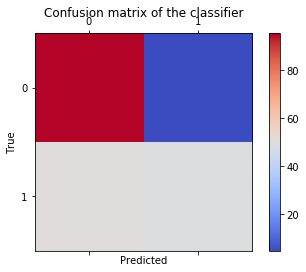

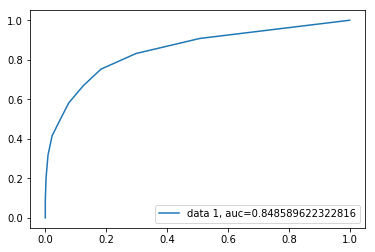


==> LogisticRegression
  Accuracy  = 0.815273 

Confusion Matrix Stats
0/0: 96.98% (1511/1558)
0/1: 3.02% (47/1558)
1/0: 81.84% (311/380)
1/1: 18.16% (69/380)


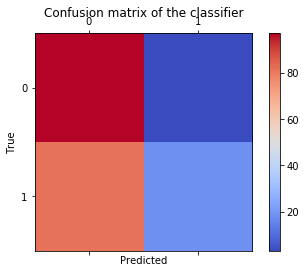

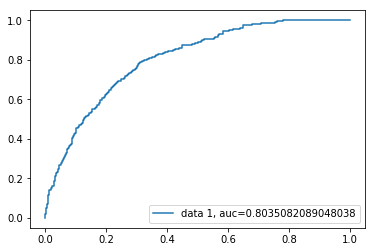


==> GaussianNB
  Accuracy  = 0.725490 

Confusion Matrix Stats
0/0: 72.85% (1135/1558)
0/1: 27.15% (423/1558)
1/0: 28.68% (109/380)
1/1: 71.32% (271/380)


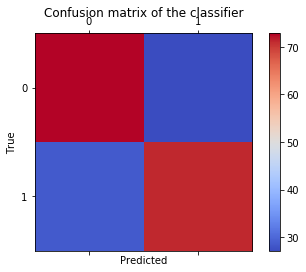

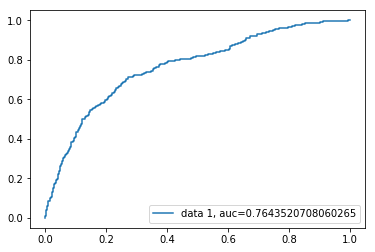


==> KNeighborsClassifier
  Accuracy  = 0.812178 

Confusion Matrix Stats
0/0: 92.81% (1446/1558)
0/1: 7.19% (112/1558)
1/0: 66.32% (252/380)
1/1: 33.68% (128/380)


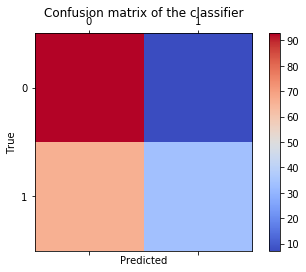

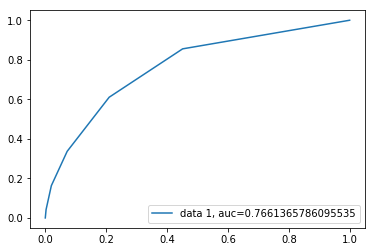


==> BaggingClassifier
  Accuracy  = 0.865841 

Confusion Matrix Stats
0/0: 96.21% (1499/1558)
0/1: 3.79% (59/1558)
1/0: 52.89% (201/380)
1/1: 47.11% (179/380)


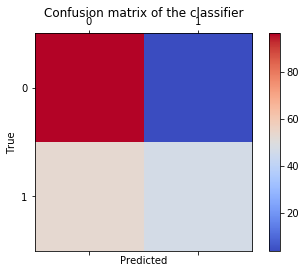

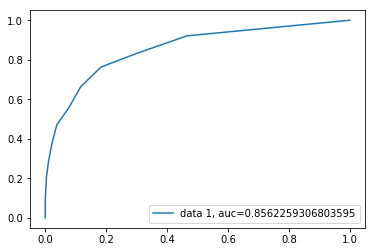

In [127]:
plot_auc = True
run_ml(x_train,x_test,y_train,y_test)


# <font color = 'red'>  2.1 - MODELOS PARA 2 CLASSES COM DADOS BALANCEADOS </font>

In [128]:
from imblearn.over_sampling import SMOTE, ADASYN
data_o, target_o = SMOTE().fit_sample(dados_clean.iloc[:,:-1],dados_clean.iloc[:,-1:], )
data_o = pd.DataFrame(data_o, columns= dados_clean.iloc[:,:-1].columns)
target_o = pd.DataFrame(target_o, columns= dados_clean.iloc[:,-1:].columns)


x_train, x_test, y_train, y_test = train_test_split(data_o,target_o, 
                                                    test_size=0.30, random_state=4)


==> SVC
  Accuracy  = 0.865768 

Confusion Matrix Stats
0/0: 81.41% (1305/1603)
0/1: 18.59% (298/1603)
1/0: 7.94% (120/1511)
1/1: 92.06% (1391/1511)


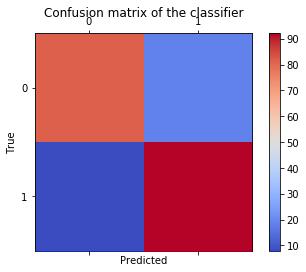


==> RandomForestClassifier
  Accuracy  = 0.884714 

Confusion Matrix Stats
0/0: 86.46% (1386/1603)
0/1: 13.54% (217/1603)
1/0: 9.40% (142/1511)
1/1: 90.60% (1369/1511)


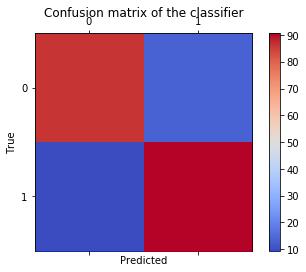

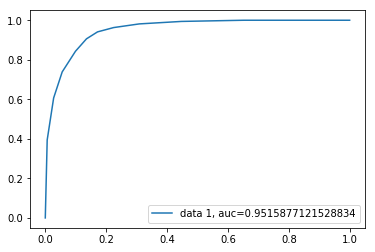


==> LogisticRegression
  Accuracy  = 0.739884 

Confusion Matrix Stats
0/0: 69.31% (1111/1603)
0/1: 30.69% (492/1603)
1/0: 21.05% (318/1511)
1/1: 78.95% (1193/1511)


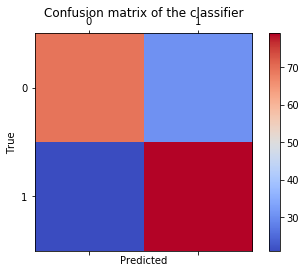

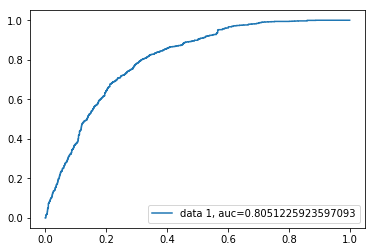


==> GaussianNB
  Accuracy  = 0.619782 

Confusion Matrix Stats
0/0: 39.43% (632/1603)
0/1: 60.57% (971/1603)
1/0: 14.10% (213/1511)
1/1: 85.90% (1298/1511)


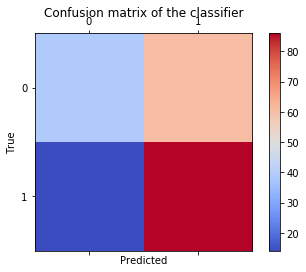

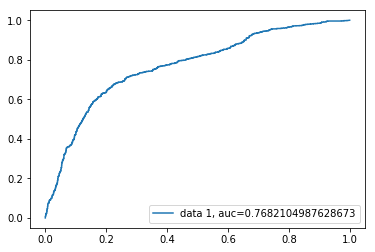


==> KNeighborsClassifier
  Accuracy  = 0.806358 

Confusion Matrix Stats
0/0: 68.75% (1102/1603)
0/1: 31.25% (501/1603)
1/0: 6.75% (102/1511)
1/1: 93.25% (1409/1511)


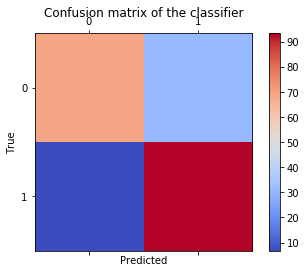

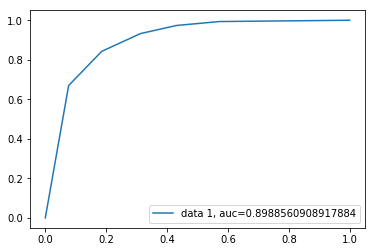


==> BaggingClassifier
  Accuracy  = 0.881182 

Confusion Matrix Stats
0/0: 87.77% (1407/1603)
0/1: 12.23% (196/1603)
1/0: 11.52% (174/1511)
1/1: 88.48% (1337/1511)


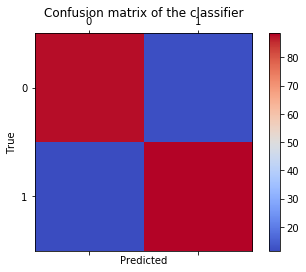

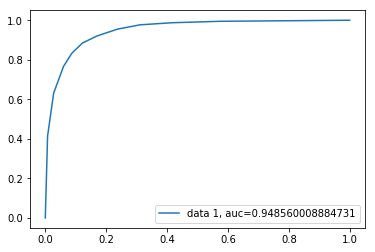


==> SVC
  Accuracy  = 0.865768 

Confusion Matrix Stats
0/0: 81.41% (1305/1603)
0/1: 18.59% (298/1603)
1/0: 7.94% (120/1511)
1/1: 92.06% (1391/1511)


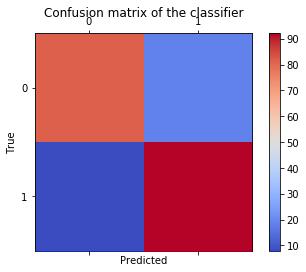


==> RandomForestClassifier
  Cols:  ['volatile acidity', 'citric acid', 'density', 'alcohol']
  Accuracy  = 0.873475 

Confusion Matrix Stats
0/0: 86.59% (1388/1603)
0/1: 13.41% (215/1603)
1/0: 11.85% (179/1511)
1/1: 88.15% (1332/1511)


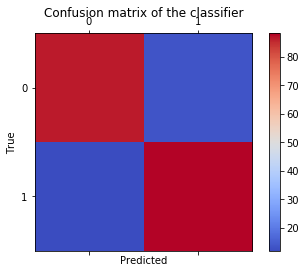

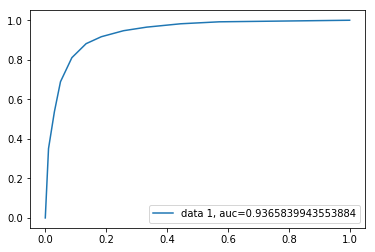


==> LogisticRegression
  Accuracy  = 0.739884 

Confusion Matrix Stats
0/0: 69.31% (1111/1603)
0/1: 30.69% (492/1603)
1/0: 21.05% (318/1511)
1/1: 78.95% (1193/1511)


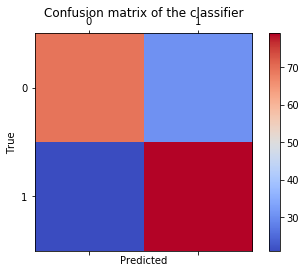

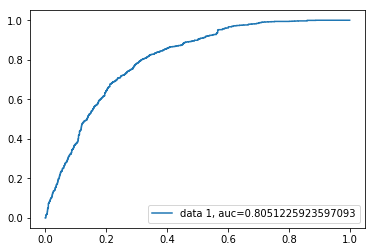


==> GaussianNB
  Accuracy  = 0.619782 

Confusion Matrix Stats
0/0: 39.43% (632/1603)
0/1: 60.57% (971/1603)
1/0: 14.10% (213/1511)
1/1: 85.90% (1298/1511)


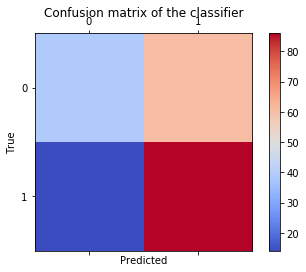

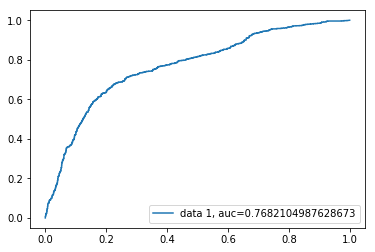


==> KNeighborsClassifier
  Accuracy  = 0.806358 

Confusion Matrix Stats
0/0: 68.75% (1102/1603)
0/1: 31.25% (501/1603)
1/0: 6.75% (102/1511)
1/1: 93.25% (1409/1511)


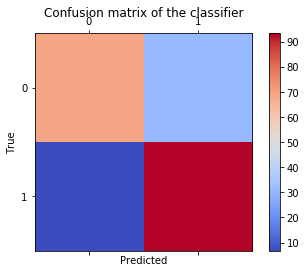

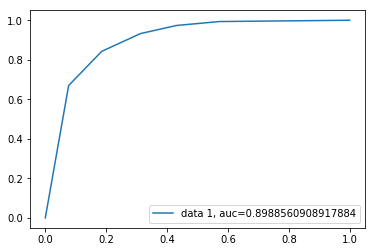


==> BaggingClassifier
  Accuracy  = 0.881182 

Confusion Matrix Stats
0/0: 87.09% (1396/1603)
0/1: 12.91% (207/1603)
1/0: 10.79% (163/1511)
1/1: 89.21% (1348/1511)


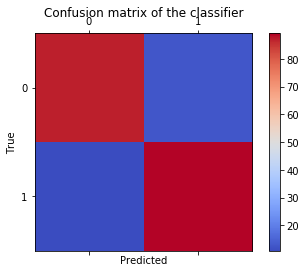

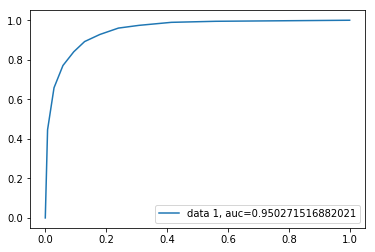

In [129]:
plot_auc = True
run_ml(x_train,x_test,y_train,y_test)
